# _SALMON_

Salmon is a package for symbolic algebra of linear regression and modeling. The goal for this package is to ease the process of model building for linear regression by separating the model (with all its interactions and variables) from the data being used to fit it. 

For the purpose of this documentation we will be using the Harris Bank dataset for our examples.

In [1]:
import pandas as pd
from salmon import *
%matplotlib inline
data = pd.read_csv("https://raw.githubusercontent.com/ajboyd2/salmon/master/harris.csv?token=ALLqgTETWQA0oazyRLEKrqqv5a7H9aO5ks5ZQNpNwA%3D%3D")
data.head(3)

,Bsal,Sal77,Sex,Senior,Age,Educ,Exper
0,5040,12420,Male,96,329,15,14.0
1,6300,12060,Male,82,357,15,72.0
2,6000,15120,Male,67,315,15,35.5


# Modeling Use Cases

Let's analyze a few use cases where we would utilize _salmon_ to model linear regression with this dataset. The format of this section will present information in the following format:

1. Present the formal model definition for a use case scenario
2. Represent the model using _salmon_
3. Fit the model and present the coefficients alongside statistics
4. Visualize the model if applicable

## Simple Linear Regression (Q)
$$\widehat{Sal77}(Bsal) = \beta_0 + \beta_1 \tt{Bsal}$$

In [2]:
explanatory = Q("Bsal") # Explanatory Expression
response = Q("Sal77") # Response Expression
model = LinearModel(explanatory, response)

Note how we did not have to specify an intercept for our explanatory expression. Should we not want an intercept, we add the `intercept = False` parameter to our model.

In [3]:
model.fit(data)

,Coefficients,SE,t,p
Intercept,4445.781845,1347.060082,3.300359,0.001385
Bsal,1.095223,0.245827,4.455251,0.000024


Also note how we didn't have to only give a data frame that consisted solely of the explanatory variables. We also didn't have to give separate data for the response. Any variables needed for the model will be extracted during fitting from `data`. Any extra columns will be ignored.

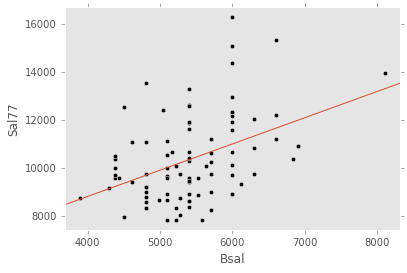

In [4]:
model.plot()

## Simple Linear Regression (C)
$$\widehat{Sal77}(Educ) = \beta_0 + \beta_1 \tt{Educ}$$

In [5]:
explanatory = C("Educ") # Explanatory Expression
response = Q("Sal77") # Response Expression
model = LinearModel(explanatory, response)

In [6]:
model.fit(data)

,Coefficients,SE,t,p
Intercept,9145.000000,476.797832,19.180037,0.000000
Educ::12,944.795918,531.987159,1.775975,0.079194
Educ::15,2148.333333,573.039677,3.749013,0.000317
Educ::16,2765.000000,953.595663,2.899552,0.004718


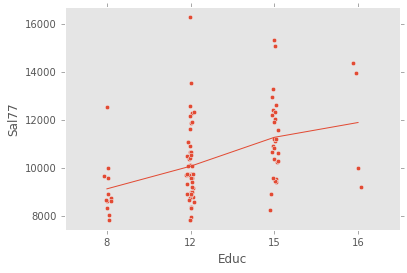

In [8]:
model.plot()

## Polynomial Regression
$$\widehat{Sal77}(Exper) = \beta_0 + \beta_1 \tt{Exper} + \beta_2 \tt{Exper}^2 + \beta_3 \tt{Exper}^3$$

In [ ]:
explanatory = Q("Exper") + Q("Exper") ** 2 + Q("Exper") ** 3 # Explanatory Expression
# --or-- #
explantory = Poly("Exper", 3)
response = Q("Sal77") # Response Expression
model = LinearModel(explanatory, response)

In [ ]:
model.fit(data)

In [ ]:
model.plot()

## Multiple Linear Regression (Q + C)
$$\widehat{Sal77}(Bsal, Educ) = \beta_0 + \beta_1 \tt{Bsal} + \beta_2 \tt{Bsal}^2 + \beta_3 \tt{Educ}$$

In [ ]:
explanatory = Q("Bsal") + Q("Bsal") ** 2 + C("Educ") # Explanatory Expression
response = Q("Sal77") # Response Expression
model = LinearModel(explanatory, response)

In [ ]:
model.fit(data)

In [ ]:
model.plot()

## Multiple Linear Regression (C's)
$$\widehat{Sal77}(Educ, Sex) = \beta_0 + \beta_1 \tt{Educ} + \beta_2 \tt{Sex}$$

In [ ]:
explanatory = C("Educ") + C("Sex") # Explanatory Expression
response = Q("Sal77") # Response Expression
model = LinearModel(explanatory, response)

In [ ]:
model.fit(data)

In [ ]:
points, indices, line_x = model.plot()

In [ ]:
pd.concat([model.training_data, model.training_y, data], axis = 1)

In [ ]:
model.training_y

In [ ]:
line_x

In [ ]:
points.loc[indices, :]

## Multiple Linear Regression (Q's)
$$\widehat{Sal77}(Bsal, Educ, Exper) = \beta_0 + \beta_1 \tt{Bsal} + \beta_2 \tt{Educ} + \beta_3 \tt{Exper}$$

In [ ]:
explanatory = Q("Bsal") + C("Educ") + Q("Exper") # Explanatory Expression
response = Q("Sal77") # Response Expression
model = LinearModel(explanatory, response)

In [ ]:
model.fit(data)

In [ ]:
# Cannot plot a model that has more than 1 quantitative variables in the explanatory expresssion

## Multiple Linear Regression w/ Interaction (C's)
$$\widehat{Sal77}(Sex, Educ) = \beta_0 + \beta_1 \tt{Sex} + \beta_2 \tt{Educ} + \gamma_{12} \tt{Sex*Educ}$$

In [ ]:
explanatory = C("Sex") + C("Educ") + C("Sex") * C("Educ") # Explanatory Expression
response = Q("Sal77") # Response Expression
model = LinearModel(explanatory, response)

In [ ]:
model.fit(data)

In [ ]:
model.plot()

## Multiple Linear Regression w/ Interaction (Q & C)
$$\widehat{Sal77}(Bsal, Educ) = \beta_0 + \beta_1 \tt{Bsal} + \beta_2 \tt{Educ} + \gamma_{12} \tt{Bsal*Educ}$$

In [ ]:
explanatory = Q("Bsal") + C("Educ") + Q("Bsal") * C("Educ") # Explanatory Expression
response = Q("Sal77") # Response Expression
model = LinearModel(explanatory, response)

In [ ]:
model.fit(data)

In [ ]:
model.plot()

## Multiple Linear Regression w/ Interaction (Poly & C)
$$\widehat{Sal77}(Exper, Educ) = \beta_0 + \beta_1 \tt{Exper} + \beta_2 \tt{Exper}^2 + \beta_3 \tt{Exper}^3 + \beta_4 \tt{Educ} + \gamma_{14} \tt{Exper*Educ} + \gamma_{24} \tt{Exper^2*Educ} + \gamma_{34} \tt{Exper^3*Educ}$$

In [ ]:
explanatory = Q("Exper") + Q("Exper") ** 2 + Q("Exper") ** 3 + C("Educ") + Q("Exper") * C("Educ") + Q("Exper") ** 2 * C("Educ") + Q("Exper") ** 3 * C("Educ") # Explanatory Expression
# --or-- #
explanatory = Poly("Exper", 3) + C("Educ") + Poly("Exper", 3) * C("Educ")
response = Q("Sal77") # Response Expression
model = LinearModel(explanatory, response)

In [ ]:
model.fit(data)

In [ ]:
model.plot()

# Other Features

For the following features, we will be using the $\widehat{Sal77}(Bsal, Sex) = \beta_0 + \beta_1 \tt{Bsal} + \beta_2 \tt{Sex} + \gamma_{12} \tt{Bsal*Sex}$ model as an example.

In [ ]:
explanatory = Q("Bsal") + C("Sex") + Q("Bsal") * C("Sex") # Explanatory Expression
response = Q("Sal77") # Response Expression
model = LinearModel(explanatory, response)
model.fit(data)

## Predicting

In [ ]:
yhat = model.predict(data)
yhat.head(5)

## Residual Plots

In [ ]:
model.residual_plots()

## Leverage Plots

In [ ]:
model.partial_plots()

# Expression Details

A model is defined by a quatitative or categorical variables existing either stand alone, within interactions, within linear combinations, or a mix of the latter two.

### Variable Types

A variable in this package represts the variables you would commonly see in a definition of a regression model like so:
$$f(\tt{Var}) = \beta_0 + \beta_1 \tt{Var_1} + \beta_2 \tt{Var_2} + \beta_3 \tt{Var_2}^2 + \gamma_{12} \tt{Var_1}*{Var_2} + \gamma_{13} \tt{Var_1} * {Var_2}^2$$
where $\tt{Var_i}$ represents either a quantitative or categorical variable. 

Salmon represents these symbolically. When defining the variables, there are three options to pick from:

In [ ]:
# Variables known to be quantitative.
quant_var = Q("Bsal")
# Variables known to be categorical.
cat_var = C("Sex")
# Variables of unknown type. These will be interpreted when fitting as either categorical or quantitative.
interp_var = Var("Educ")

The string passed into the variables are the column names to extract from a pandas `DataFrame` when fitting on a set of data. So for instance, if we defined a model with `Q("Bsal")` then the model would extract the `Bsal` column to work with from the data passed in.

#### Quantitative Variables
Common transformations of quantitative variables are also supported. For example:

In [ ]:
bsal_squared = Q("Bsal") ** 2
bsal_shifted = Q("Bsal") + 150
bsal_logged = Log(Q("Bsal"))

#### Categorical Variables

When defining categorical variables it is possible to set ahead of time the possible levels/factors to fit with, as well as the encoding method for use. For instance, if we wanted to treat the `Educ` column in our example dataset as a categorical variable, and we knew the possible levels of education were either 8, 10, 12, 15, or 16, then we could define our variable as follows:

In [ ]:
educ_var_v1 = C("Educ", method = 'one-hot', levels = [8, 10, 12, 15, 16])
educ_var_v2 = C("Educ", method = 'one-hot', levels = [8, 10, 12])

The first variable defined set the order of the levels to interpreted as. This would matter with encoding methods such as ordinal encoding (note: currently not supported, only one-hot encoding is supported at this time). In our case with the one-hot encoding method used, our ordering designated the '8' level to be dropped to avoid multi-colinearity.

The second variable defined still designated the '8' level to be dropped; however, it also designates that any levels found in the data that are not either '8', '10', or '12' will be binned into an 'other' category.

By default, categorical variables will use a one-hot encoding method and will dynamically extract the possible levels of a variable upon fitting. The levels will be ordered by sorting and the smallest (according to Python's `sorted` function) level will be dropped. 

## Combinations

Many regression applications require multiple variables within the model. This is achieved in salmon by simply adding together several variables. For instance, suppose we wanted to represent:
$$\tt{Sex} + \tt{Bsal} + \tt{Bsal}^2$$
This would be achieved like so:

In [ ]:
combo = C("Sex") + Q("Bsal") + Q("Bsal") ** 2

Should you want to define an full polynomial sequence you can use the following command as well:

In [ ]:
combo = C("Sex") + Poly("Bsal", 4) # Expands to 'Sex + Bsal + Bsal^2 + Bsal^3 + Bsal^4'

## Interactions

It is common to want to model interaction effects between variables. Salmon supports this symbolically using the `*` operator. Any combination of variable type is supported.

For example, let's model this interaction:
$$\tt{Sex * Bsal}$$

In [ ]:
interaction = C("Sex") * Q("Bsal")

Here is how we would model a more complicated linear combination of variables and interactions like $$\tt{Sex} + \tt{Bsal} + \tt{Bsal}^2 + \tt{Sex * Bsal} + \tt{Sex}*{Bsal}^2$$


In [ ]:
complicated_combo = C("Sex") + Q("Bsal") + Q("Bsal")**2 + C("Sex")*Q("Bsal") + C("Sex")*Q("Bsal")**2

Salmon also supports distribution of singular terms into combinations. The above expression could be represented more succinctly as such:

In [ ]:
# Equivalent to C("Sex") + Q("Bsal") + Q("Bsal")**2 + (Q("Bsal") + Q("Bsal")**2) * C("Sex") 
complicated_combo = C("Sex") + Poly("Bsal", 2) + Poly("Bsal", 2) * C("Sex")

## Representing the Model

Now that we understand how to form expressions of variables, we can now represent our models. `LinearModels` are always defined of the form:

`model = LinearModel(explanatory_expression, response_expression)`

The `explanatory_expression` is allowed to be a single term, an interaction, or a combination of the other two. The `response_expression` is allowed to be either a single term or an interaction. Categorical variables are allowed within the `response_expression` so long after encoding the resultant expansion is represented by only one column.